In [ ]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df = pd.read_csv('/content/drive/MyDrive/Deep_learning-datasets/Energy_Production.csv',index_col=0,parse_dates=True)
df.dropna(inplace=True)
print(len(df))
df.head()

325


,IPG2211A2N
DATE,
1992-01-01,85.5560
1992-02-01,80.4178
1992-03-01,74.7390
1992-04-01,69.8367
1992-05-01,67.3781


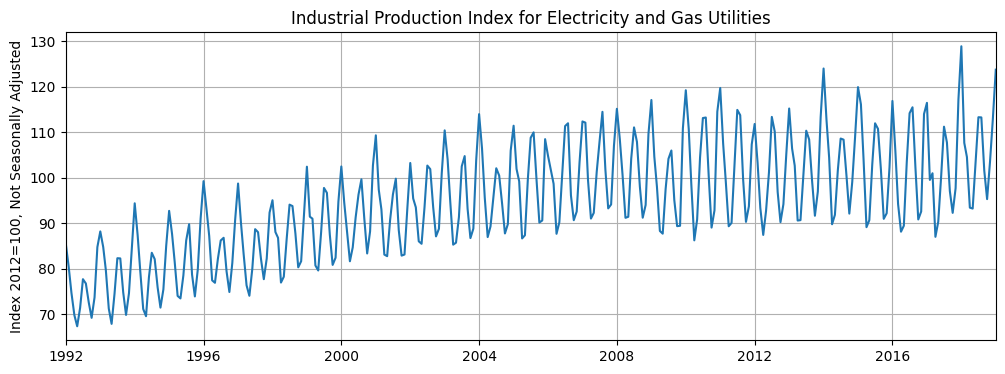

In [ ]:
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.show()

In [ ]:
y = df['IPG2211A2N'].values.astype(float)

test_size = 12
window_size = 12

train_set = y[:-test_size]
test_set = y[-test_size:]

In [ ]:
print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 313
Test:  12


In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_set.reshape(-1,1))
train_norm = scaler.transform(train_set.reshape(-1,1))

In [ ]:
print(f'First item, original: {train_set[0]}')
print(f'First item, scaled:  {train_norm[0]}')

First item, original: 85.556
First item, scaled:  [-0.4091274]


In [ ]:
train_norm = torch.FloatTensor(train_norm).view(-1)

In [ ]:
def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [ ]:
train_data = input_data(train_norm,window_size)

In [ ]:
print(f'Train_data: {len(train_data)}')

Train_data: 301


In [ ]:
class GRUnetwork(nn.Module):
  def __init__(self,input_size=1,hidden_size=275,output_size=1):
    super().__init__()
    self.hidden_size = hidden_size
    self.gru = nn.GRU(input_size,hidden_size)
    self.linear = nn.Linear(hidden_size,output_size)
    self.hidden = torch.zeros(1,1,self.hidden_size)
  def forward(self,seq):
    gru_out,self.hidden = self.gru(seq.view(len(seq),1,-1),self.hidden)
    pred = self.linear(gru_out.view(len(seq),-1))
    return pred[-1]

In [ ]:
torch.manual_seed(101)
model = GRUnetwork()
model

GRUnetwork(
  (gru): GRU(1, 275)
  (linear): Linear(in_features=275, out_features=1, bias=True)
)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
epochs = 100
import time
start_time = time.time()
for epoch in range(epochs):
  for seq,y_train in train_data:
    optimizer.zero_grad()
    model.hidden = torch.zeros(1,1,model.hidden_size)
    y_pred = model(seq)
    loss = criterion(y_pred,y_train)
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch+1} Loss {loss.item()}")
total_time = time.time() - start_time
print(f"Training took {total_time/60:.2f} minutes")

Epoch 1 Loss 0.3116660416126251
Epoch 2 Loss 0.275699257850647
Epoch 3 Loss 0.25080040097236633
Epoch 4 Loss 0.23241053521633148
Epoch 5 Loss 0.21463632583618164
Epoch 6 Loss 0.19824881851673126
Epoch 7 Loss 0.18128952383995056
Epoch 8 Loss 0.16165341436862946
Epoch 9 Loss 0.14243534207344055
Epoch 10 Loss 0.12791354954242706
Epoch 11 Loss 0.11779583245515823
Epoch 12 Loss 0.10941535234451294
Epoch 13 Loss 0.10139444470405579
Epoch 14 Loss 0.09427438676357269
Epoch 15 Loss 0.0871291309595108
Epoch 16 Loss 0.08038198947906494
Epoch 17 Loss 0.07408206164836884
Epoch 18 Loss 0.06856754422187805
Epoch 19 Loss 0.06364892423152924
Epoch 20 Loss 0.059149257838726044
Epoch 21 Loss 0.054867733269929886
Epoch 22 Loss 0.050784189254045486
Epoch 23 Loss 0.04731588438153267
Epoch 24 Loss 0.04527956247329712
Epoch 25 Loss 0.0445123091340065
Epoch 26 Loss 0.04506298899650574
Epoch 27 Loss 0.04658322036266327
Epoch 28 Loss 0.05078169330954552
Epoch 29 Loss 0.057316310703754425
Epoch 30 Loss 0.06241089

In [ ]:
future = 12
preds = train_norm[-window_size:].tolist()
model.eval()

for i in range(future):
  seq = torch.FloatTensor(preds[-window_size:])
  with torch.no_grad():
    model.hidden = torch.zeros(1,1,model.hidden_size)
    preds.append(model(seq).item())

In [ ]:
preds[window_size:]

[0.4576861262321472,
 0.5572227239608765,
 -0.16553321480751038,
 -0.20149749517440796,
 0.1615358293056488,
 0.3058570325374603,
 0.3600957989692688,
 0.13567622005939484,
 -0.13331574201583862,
 0.0856713280081749,
 0.4298834800720215,
 0.9884235858917236]

In [ ]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))

In [ ]:
true_predictions

array([[112.22308483],
       [115.28527849],
       [ 93.05005341],
       [ 91.94363031],
       [103.11216902],
       [107.55213868],
       [109.22076721],
       [102.31661107],
       [ 94.04120785],
       [100.77823557],
       [111.36775032],
       [128.55095741]])

In [ ]:
df['IPG2211A2N'][-12:]

,IPG2211A2N
DATE,
2018-02-01,107.6711
2018-03-01,104.5716
2018-04-01,93.4491
2018-05-01,93.2405
2018-06-01,103.3083
2018-07-01,113.3178
2018-08-01,113.2758
2018-09-01,101.5656
2018-10-01,95.3203


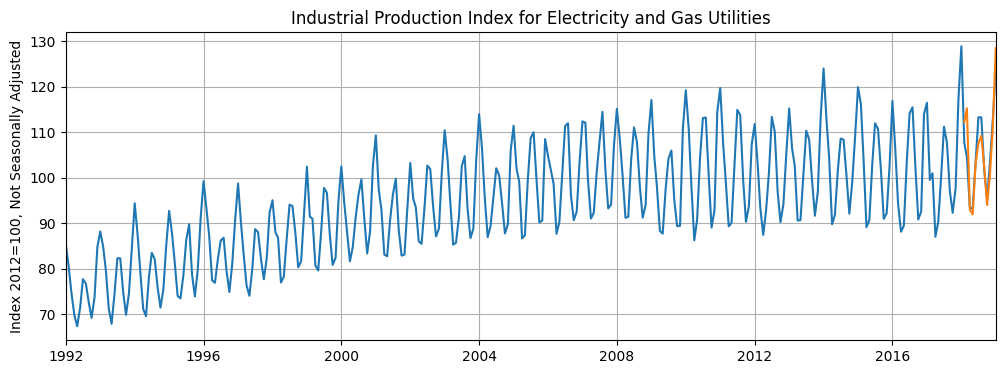

In [ ]:
x = np.arange('2018-02-01','2019-02-01',dtype='datetime64[M]')
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x,true_predictions)
plt.show()

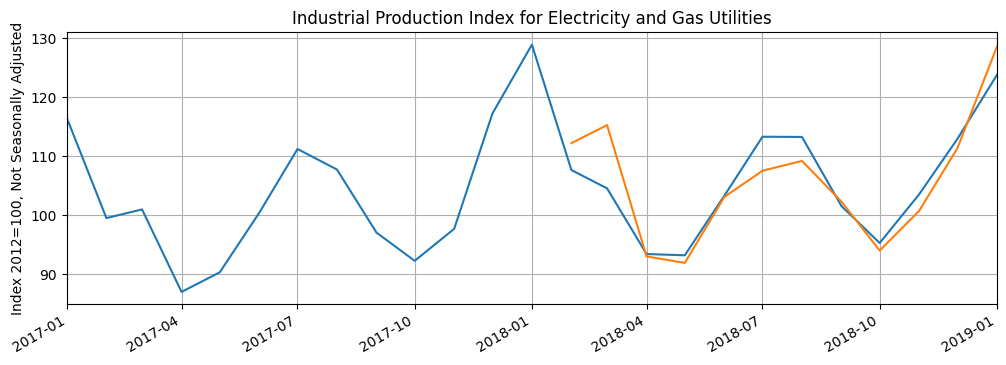

In [ ]:
fig = plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['IPG2211A2N']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

In [ ]:
epochs = 100

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):

    # train on the full set of sequences
    for seq, y_train in all_data:

        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = torch.zeros(1,1,model.hidden_size)

        y_pred = model(seq)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.01505255
Epoch:  2 Loss: 0.00083786
Epoch:  3 Loss: 0.00026942
Epoch:  4 Loss: 0.00353380
Epoch:  5 Loss: 0.02556685
Epoch:  6 Loss: 0.05486318
Epoch:  7 Loss: 0.00460988
Epoch:  8 Loss: 0.00356566
Epoch:  9 Loss: 0.00176797
Epoch: 10 Loss: 0.00096400
Epoch: 11 Loss: 0.00144306
Epoch: 12 Loss: 0.00063239
Epoch: 13 Loss: 0.00153195
Epoch: 14 Loss: 0.00799086
Epoch: 15 Loss: 0.00027053
Epoch: 16 Loss: 0.00024955
Epoch: 17 Loss: 0.00211650
Epoch: 18 Loss: 0.00089449
Epoch: 19 Loss: 0.00038267
Epoch: 20 Loss: 0.00034326
Epoch: 21 Loss: 0.01263062
Epoch: 22 Loss: 0.00085140
Epoch: 23 Loss: 0.00762788
Epoch: 24 Loss: 0.00045719
Epoch: 25 Loss: 0.00003746
Epoch: 26 Loss: 0.00002504
Epoch: 27 Loss: 0.00229874
Epoch: 28 Loss: 0.00122933
Epoch: 29 Loss: 0.00273637
Epoch: 30 Loss: 0.00000028
Epoch: 31 Loss: 0.00192817
Epoch: 32 Loss: 0.00064602
Epoch: 33 Loss: 0.00028123
Epoch: 34 Loss: 0.00003336
Epoch: 35 Loss: 0.00377197
Epoch: 36 Loss: 0.03283032
Epoch: 37 Loss: 0.00032358
E

In [ ]:
window_size = 12
future = 12
preds = y_norm[-window_size:].tolist()
model.eval()
for i in range(future):
  seq = torch.FloatTensor(preds[-window_size:])
  with torch.no_grad():
    model.hidden = torch.zeros(1,1,model.hidden_size)
    preds.append(model(seq).item())

In [ ]:
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1,1))

In [ ]:
true_predictions

array([[107.67110043],
       [104.57159999],
       [ 93.44910017],
       [ 93.24049994],
       [103.30830004],
       [113.31779971],
       [113.27579957],
       [101.56560006],
       [ 95.32029992],
       [103.5749999 ],
       [112.94980037],
       [123.76870065],
       [115.11581645],
       [102.63409912],
       [ 91.99337466],
       [ 96.56684048],
       [110.81304843],
       [119.99794973],
       [108.31887121],
       [101.58711334],
       [ 91.85889975],
       [ 97.88965203],
       [109.227121  ],
       [119.13702242]])

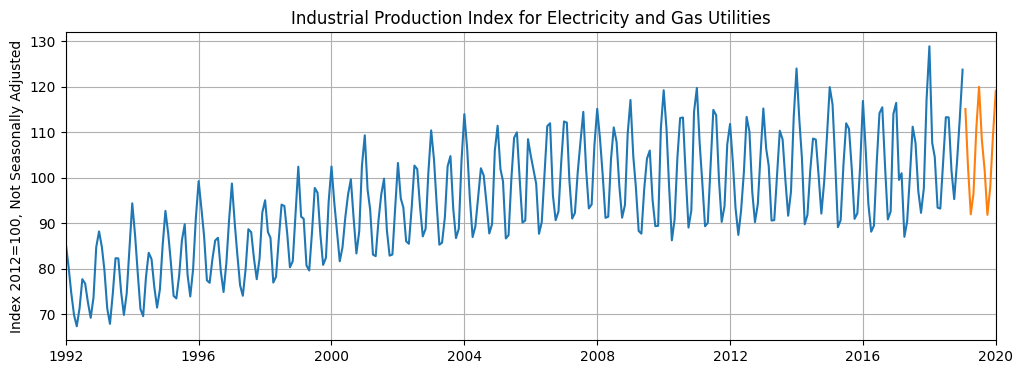

In [ ]:
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x,true_predictions[window_size:])
plt.show()

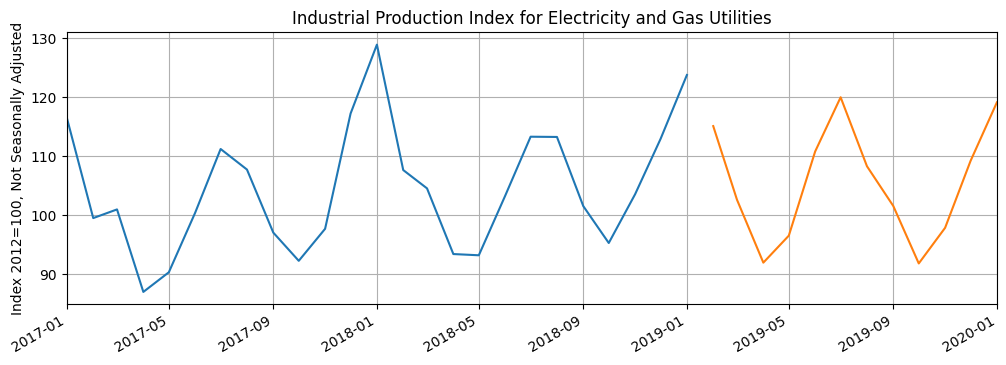

In [ ]:
fig = plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['IPG2211A2N']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()